In [2]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd

V_p_p = 5

get_cutoff = lambda R, C: 1 / (2 * np.pi * R * C)

def read_mixed_csv(file_path):
    # Read the CSV file
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Split metadata and data
    metadata = {}
    data_start = False
    data = []

    for line in lines:
        line = line.strip()
        
        if line == 'DATA':
            data_start = True
            continue
        
        if not data_start:
            # Split by comma to get the key-value pair
            key, value = line.split(',', 1)
            metadata[key.strip()] = value.strip()
        else:
            # Split data points (assuming the format is consistent)
            x, y = line.split(',')
            data.append([float(x), float(y)])
    
    # Convert data to DataFrame
    df_data = pd.DataFrame(data, columns=["Frequency (Hz)", "Value (dBm)"])

    return metadata, df_data

def sort_by_first(l1: list, l2: list):
    """
    Sorts two lists in ascending order based on the first list.
    """
    combined = sorted(zip(l1, l2))
    sorted_list1, sorted_list2 = zip(*combined)
    return list(sorted_list1), list(sorted_list2)

def scientific_2_str(value: float, unit: str = "Ω") -> str:
    prefixes = [
        (1e9, 'G'),
        (1e6, 'M'),
        (1e3, 'k'),
        (1, ''),
        (1e-3, 'm'),
        (1e-6, 'µ'),
        (1e-9, 'n'),
        (1e-12, 'p')
    ]

    for factor, prefix in prefixes:
        if abs(value) >= factor:
            formatted = value / factor
            return f"{formatted:.3g} {prefix}{unit}"
    return f"{value:.3g} {unit}"  # fallback for very small values


def plot(x: NDArray, 
             y: NDArray,
             title: str,
             x_label: str="Resistance [Ohm]",
             y_label: str="Frequency [Hz]",
             x_log: bool=False,
             y_log: bool=False):

    plt.figure(figsize=(8, 4))

    if x_log and y_log:
        plt.loglog(x, y, marker='o')
    elif x_log:
        plt.semilogx(x, y, marker='o')
    elif y_log:
        plt.semilogy(x, y, marker='o')
    else:
        plt.plot(x, y, marker='o')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


For f_min GND at VCO_1,IN

3.1.1.1 a

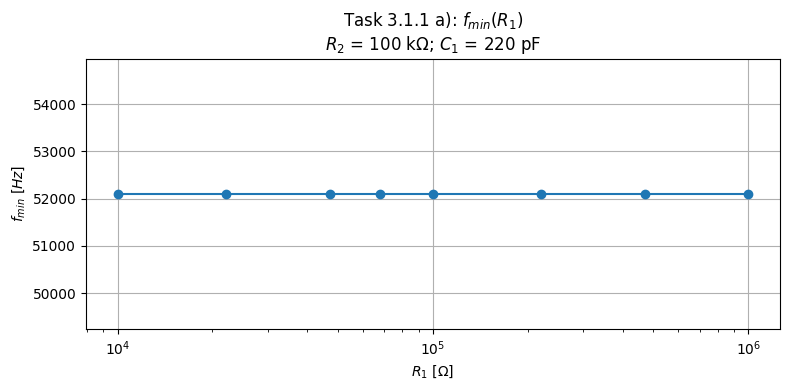

In [3]:
R_2 = 100e3
C_1 = 220e-12

R_1   = [22e3,   10e3,   47e3,   68e3,   100e3,  220e3,  470e3,  1e6]
f_min = [52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3, 52.1e3]

R_1, f_min  = sort_by_first(R_1, f_min)

title: str = (r"Task 3.1.1 a): $f_{min}(R_1)$" + 
            f"\n$R_2$ = {scientific_2_str(R_2)}; $C_1$ = {scientific_2_str(C_1, "F")}")
plot(R_1, f_min, title, x_log=True, y_label=r"$f_{min}$ $[Hz]$", x_label=r"$R_1$ $[\Omega]$")

3.1.1.1 b

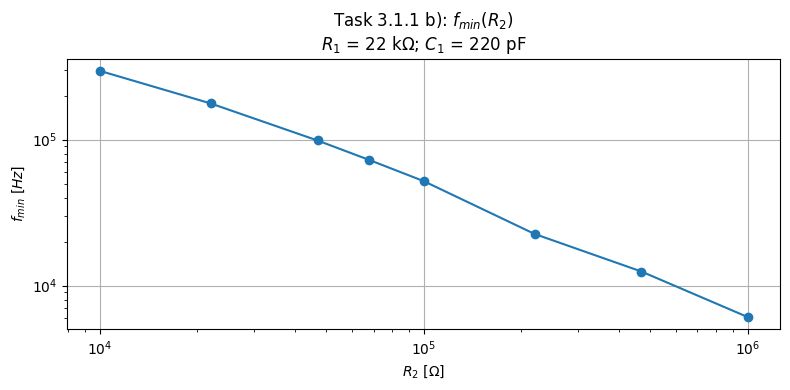

In [4]:
V_p_p = 5
R_1 = 22e3
C_1 = 220e-12

R_2 =   [10e3,  22e3,  47e3,   68e3,   100e3, 220e3,  470e3,  1e6]
f_min = [296e3, 177e3, 98.7e3, 72.5e3, 52e3,  22.6e3, 12.5e3, 6.1e3]

title = (r"Task 3.1.1 b): $f_{min}(R_2)$" +
          f"\n$R_1$ = {scientific_2_str(R_1)}; $C_1$ = {scientific_2_str(C_1, "F")}")
plot(R_2, f_min, title, y_log=True, x_log=True, y_label=r"$f_{min}$ $[Hz]$", x_label=r"$R_2$ $[\Omega]$")

3.1.1.1 c

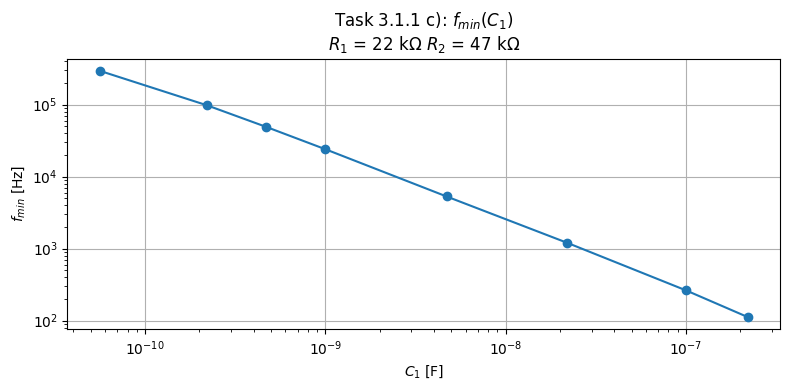

In [5]:
V_p_p = 5
R_1 = 22e3
R_2 = 47e3

C_1 =   [56e-12, 220e-12, 470e-12, 1e-9, 4.7e-9, 22e-9, 100e-9, 220e-9]
f_min = [295e3,  98e3,    49e3,    24e3, 5.3e3,  1.2e3, 263   , 112]

title = (r"Task 3.1.1 c): $f_{min}(C_1)$"+
         f"\n$R_1$ = {scientific_2_str(R_1)} $R_2$ = {scientific_2_str(R_2)}")
plot(C_1, f_min, title, x_log=True, y_log=True, x_label=r"$C_1$ [F]", y_label=r"$f_{min}$ [Hz]")


3.1.1.2

For f_max 5V on VCO_1_IN

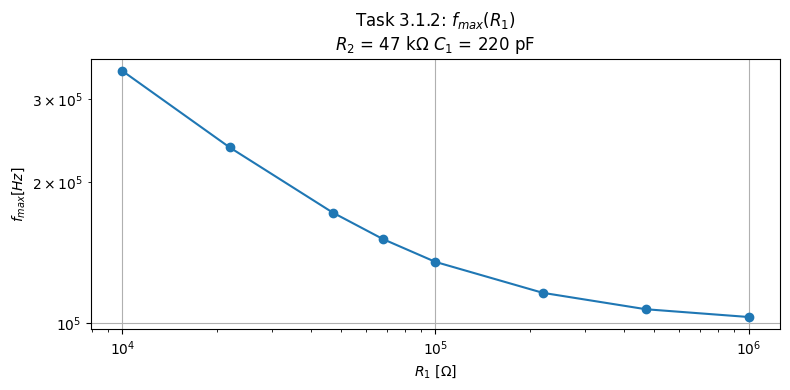

In [6]:
R_2 = 47e3
C_1 = 220e-12

R_1 =   [22e3,  10e3,  47e3,  68e3,  100e3, 220e3, 470e3, 1e6]
f_max = [237e3, 345e3, 172e3, 151e3, 135e3, 116e3, 107e3, 103e3]

R_1, f_max = sort_by_first(R_1, f_max)

title = (r"Task 3.1.2: $f_{max}(R_1$)"+
         f"\n$R_2$ = {scientific_2_str(R_2)} $C_1$ = {scientific_2_str(C_1, "F")}")
plot(R_1, f_max, title,
     y_log=True, x_log=True,
     y_label=r"$f_{max} [Hz]$",
     x_label=r"$R_1$ $[\Omega]$")

### 3.1.3: Would you have expected the behavior from 1. and 2. above? Why? <br> Please elaborate including potential references to the applicable datasheet figures

3.1.2.1

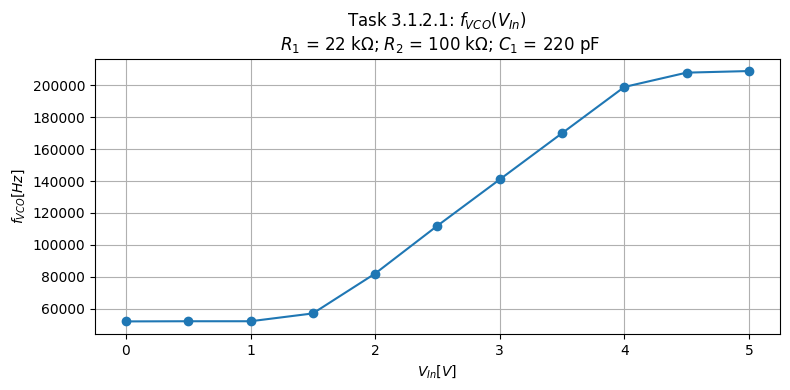

In [7]:
R_1 = 22e3
R_2 = 100e3
C_1 = 220e-12

V_in =  [0,     0.5,    1,      1.5,  2,    2.5,   3,     3.5,   4.0,   4.5,   5]
f_vco = [52.e3, 52.1e3, 52.1e3, 57e3, 82e3, 112e3, 141e3, 170e3, 199e3, 208e3, 209e3]

title = ("Task 3.1.2.1: $f_{VCO}(V_{In})$" +
        f"\n $R_1$ = {scientific_2_str(R_1)}; $R_2$ = {scientific_2_str(R_2)}; $C_1$ = {scientific_2_str(C_1, "F")}")
plot(V_in, f_vco, title, x_label="$V_{In} [V]$", y_label="$f_{VCO} [Hz]$")

3.1.3

In [8]:
R_f  = 56e3
C_f = 1e-9

f_c = get_cutoff(R_f, C_f)
print(f"Cutoff Freq: {f_c:.0f} Hz")

f_H_min = 55e3
print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")
f_H_max = 193e3
print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")

f_f_min = 87e3
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")

f_f_max = 138e3
print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")


Cutoff Freq: 2842 Hz
Min. Hold Freq.: 55000 Hz
Max. Hold Freq.: 193000 Hz
Min. Pull-In Freq.: 87000 Hz
Max. Pull-In Freq.: 138000 Hz


3.1.3.2

In [9]:
R_f_max = 100e3
C_f_min = 5.6e-9

f_c_min = get_cutoff(R_f_max, C_f_min)
print(f_c_min)

f_H_max = 200e3
print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")

f_H_min = 55e3
print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")

f_f_max = 123e3
print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")

f_f_min = 105e3
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")


284.2052555212417
Max. Hold Freq.: 200000 Hz
Min. Hold Freq.: 55000 Hz
Max. Pull-In Freq.: 123000 Hz
Min. Pull-In Freq.: 105000 Hz


3.1.3.3

In [10]:
R_f_min = 10e3
C_f_min = 560e-12

f_c_max = get_cutoff(R_f_min, C_f_min)
print(f_c_max)

f_H_max = 200e3
f_f_max = 200e3
f_H_min = 55e3
f_f_min = 56e3

print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")
print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")
print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")

28420.525552124167
Max. Pull-In Freq.: 200000 Hz
Min. Pull-In Freq.: 56000 Hz
Min. Hold Freq.: 55000 Hz
Max. Hold Freq.: 200000 Hz


3.1.3.5

In [11]:
R_f = 10e3
C_f = 1.8e-9

f_H_max = 200e3
f_f_max = 158e3
f_H_min = 55e3
f_f_min = 67e3

print(f"Max. Pull-In Freq.: {f_f_max:.0f} Hz")
print(f"Min. Pull-In Freq.: {f_f_min:.0f} Hz")
print(f"Min. Hold Freq.: {f_H_min:.0f} Hz")
print(f"Max. Hold Freq.: {f_H_max:.0f} Hz")

Max. Pull-In Freq.: 158000 Hz
Min. Pull-In Freq.: 67000 Hz
Min. Hold Freq.: 55000 Hz
Max. Hold Freq.: 200000 Hz


3.2.2 a

In [ ]:
RBW = 1e3
VBW = 30
span = 50e3

freq_offset = [1e3, 2e3, 5e3, 10e3, 25e3]

a, b = read_mixed_csv("Meassurements_Spectrum_Analyzer/Ampcor_0000.csv")
pass

FileNotFoundError: [Errno 2] No such file or directory: 'Lab7_PLL/Meassurements_Spectrum_Analyzer/Ampcor_0000.csv'

3.2.2 b